In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import numpy as np
import sklearn as sk

pd.options.display.max_columns = None

# Data Initialization
flood_df = pd.read_csv('data/flooding_events_augmented.csv', dtype=str, keep_default_na=False)
non_flood_df = pd.read_csv('data/non_flooding_events_normal_augmented.csv', dtype=str, keep_default_na=False)
county_test_df = pd.read_csv('data/testing_county_data.csv', dtype=str, keep_default_na=False)

In [2]:
# Robust missing detector (so blanks like "", "NA", "null" count as missing)
MISSING_TOKENS = {"", " ", "na", "n/a", "null", "none", "nan"}
def is_na_like(s):
    s = str(s).strip().lower()
    return s in MISSING_TOKENS

In [3]:
KNOWN_NUMERIC = [
    "YEAR", "MONTH", "BEGIN_DAY", "BEGIN_TIME", "BEGIN_LAT", "BEGIN_LON", "temperature_2m_mean", 
    "wind_speed_10m_mean", "cloud_cover_mean", "relative_humidity_2m_mean", "dew_point_2m_mean", 
    "precipitation_sum", "rain_sum", "snowfall_sum", "pressure_msl_mean", "soil_moisture_0_to_10cm_mean", 
    "elevation"
]
def coerce_numeric(df):
    # Try to coerce known numeric columns; leave others as text
    present_numeric = [c for c in KNOWN_NUMERIC if c in df.columns]
    for c in present_numeric:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [4]:
def output_missing(df, name):
    miss_rows = []
    for c in df.columns:
        if c in [col for col in KNOWN_NUMERIC if col in df.columns]:
            miss = df[c].isna().sum()
        else:
            miss = df[c].apply(is_na_like).sum()
        miss_rows.append({"column": c, "missing": int(miss), "missing_%": round(miss*100/len(flood_df), 2)})
    miss_df = pd.DataFrame(miss_rows).sort_values("missing", ascending=False)
    print(f"\n=== MISSING VALUES (robust) for the {name} dataset ===")
    print(miss_df.to_string(index=False))

In [5]:
def explore_data_shape(df, name):
    print(f"=== {name} DATA SHAPE & COLUMNS ===")
    print(f"Rows: {len(df):,}  |  Columns: {len(df.columns)}")
    print("Columns:", ", ".join(df.columns))
    print("\n=== HEAD(10) ===")
    print(df.head(10).to_string(index=False))
    print("\n=== TAIL(5) ===")
    print(df.tail(5).to_string(index=False))
    print('\n')

In [6]:
def describe_numeric(df, name):
    if [c for c in KNOWN_NUMERIC if c in df.columns]:
        desc = df[[c for c in KNOWN_NUMERIC if c in df.columns]].describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).T
        desc = desc.rename(columns={"50%":"median"}).reset_index().rename(columns={"index":"column"})
        print(f"\n=== NUMERIC STATS (describe) for {name} ===")
        print(desc.round(3).to_string(index=False))
    else:
        print(f"\n(No numeric columns in {name} found to describe.)")

In [7]:
def explore_categorical(df, name):
    cat_cols = ["EVENT_TYPE"]
    
    if cat_cols:
        print(f"\n=== CATEGORICAL STATS (describe for object) in {name} ===")
        print(df[cat_cols].describe(include=['object']).to_string())
        print(f"\n=== CATEGORICAL VALUE COUNTS (top 20 each) in {name} ===")
        for col in cat_cols:
            s = df[col].astype(str)
            s = s.where(~s.apply(is_na_like), "<MISSING>")
            vc = s.value_counts(dropna=False)
            top = vc.head(20)
            print("-"*100)
            print(f"{col} | distinct={vc.shape[0]} | top 20 shown")
            print(pd.DataFrame({"value": top.index, "count": top.values, "percent": (top.values/len(s)*100).round(2)}).to_string(index=False))
            ax = top.sort_values(ascending=True).plot.barh(figsize=(8, 0.3*len(top)), title=col)
            ax.set_xlabel("Count")
            plt.tight_layout()
            plt.show()
    else:
        print(f"\n(No categorical columns in {name} detected under current rules.)")

In [8]:
def explore_numeric(col, df, name, bins=50):
    print(f" --- {name} ---\n")
    if col not in df.columns:
        print(f"{col} not found"); return
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    if s.empty:
        print(f"{col}: no numeric data"); return
    fig, axes = plt.subplots(1,2, figsize=(12,4))
    fig.suptitle(col)
    axes[0].hist(s, bins=bins); axes[0].set_title("Histogram"); axes[0].grid(True, alpha=0.3)
    axes[1].boxplot(s, vert=True, showfliers=True); axes[1].set_title("Boxplot"); axes[1].grid(True, axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
    print(s.describe(percentiles=[0.01,0.05,0.25,0.5,0.75,0.95,0.99]).round(3))

def visualize_categorical(col, df, name, top_n=30):
    print(f" --- {name} ---\n")
    if col not in df.columns:
        print(f"{col} not found"); return
    s_raw = df[col].astype(str)
    s = s_raw.where(~s_raw.apply(is_na_like), "<MISSING>")
    vc = s.value_counts()
    print(f"{col} | distinct={vc.shape[0]} | total={len(s)} | missing={(s=='<MISSING>').sum()}")
    show = vc.head(top_n)
    print(pd.DataFrame({
        "value": show.index,
        "count": show.values,
        "percent": (show.values/len(s)*100).round(2)
    }).to_string(index=False))
    ax = show.sort_values(ascending=True).plot.barh(figsize=(8, 0.3*len(show)), title=col)
    ax.set_xlabel("Count")
    plt.tight_layout()
    plt.show()

In [9]:
def clean_data(df):
    df.drop('snowfall_sum', axis=1, inplace=True)
    df.drop('BEGIN_DAY', axis=1, inplace=True)

    df.dropna(subset=['soil_moisture_0_to_10cm_mean'], inplace=True)

    df = df.sort_values('precipitation_sum')
    df['rain_sum'] = df['rain_sum'].interpolate(method='nearest')
    df = df.sort_index()

    return df

In [10]:
def engineer_data(df):
    primary_rainy_months = [3, 4, 5]
    secondary_rainy_months = [9, 10]
    df['is_primary_rain_season'] = df['MONTH'].isin(primary_rainy_months)
    df['is_secondary_rain_season'] = df['MONTH'].isin(secondary_rainy_months)
    return df

In [11]:
import geopandas as gpd
from shapely.geometry import Point

def categorize_flood_zones(flood_df, non_flood_df, county_test_df):
    all_lats = pd.concat([flood_df['BEGIN_LAT'], non_flood_df['BEGIN_LAT'], county_test_df['BEGIN_LAT']])
    all_lons = pd.concat([flood_df['BEGIN_LON'], non_flood_df['BEGIN_LON'], county_test_df['BEGIN_LON']])
    
    minx, miny, maxx, maxy = all_lons.min(), all_lats.min(), all_lons.max(), all_lats.max()
    bbox_polygon = gpd.GeoSeries([Point(minx, miny), Point(maxx, maxy)], crs="EPSG:4326").envelope
    bbox_reprojected = tuple(bbox_polygon.to_crs("EPSG:4269").total_bounds)
    
    gdb_path = "./data/NFHL_48_20251201.gdb" 
    layer_name = "S_Fld_Haz_Ar"
    
    try:
        gdf_flood = gpd.read_file(gdb_path, layer=layer_name, bbox=bbox_reprojected)
    except Exception as e:
        print(f"bbox read failed, trying full load. Error: {e}")
        gdf_flood = gpd.read_file(gdb_path, layer=layer_name)
    
    gdf_flood = gdf_flood.to_crs("EPSG:4326")
    
    def enrich_with_flood_zone_data(input_df, flood_zones_gdf):
        
        geometry = [Point(xy) for xy in zip(input_df['BEGIN_LON'], input_df['BEGIN_LAT'])]
        gdf_temp = gpd.GeoDataFrame(input_df, geometry=geometry, crs="EPSG:4326")
    
        joined = gpd.sjoin(gdf_temp, flood_zones_gdf, how="left", predicate="within")
    
        joined = joined[~joined.index.duplicated(keep='first')]
    
        input_df['Flood_Zone'] = joined['FLD_ZONE']
        
        high_risk_codes = ['A', 'AE', 'AH', 'AO', 'AR', 'A99', 'V', 'VE']
        input_df['Is_In_Floodplain'] = input_df['Flood_Zone'].isin(high_risk_codes)
    
        return input_df
    
    flood_df = enrich_with_flood_zone_data(flood_df, gdf_flood)
    non_flood_df = enrich_with_flood_zone_data(non_flood_df, gdf_flood)
    county_test_df = enrich_with_flood_zone_data(county_test_df, gdf_flood)
    
    print(flood_df[['BEGIN_LAT', 'BEGIN_LON', 'Flood_Zone', 'Is_In_Floodplain']].head())
    print(non_flood_df[['BEGIN_LAT', 'BEGIN_LON', 'Flood_Zone', 'Is_In_Floodplain']].head())

    return flood_df, non_flood_df, county_test_df

In [12]:
def plot_flood_zones():
    usa_url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_5m.json"
    usa_gdf = gpd.read_file(usa_url)
    texas_map = usa_gdf[usa_gdf['NAME'] == 'Texas']
    
    gdf_flood_points = gpd.GeoDataFrame(
        flood_df, geometry=[Point(xy) for xy in zip(flood_df['BEGIN_LON'], flood_df['BEGIN_LAT'])], crs="EPSG:4326"
    )
    gdf_non_flood_points = gpd.GeoDataFrame(
        non_flood_df, geometry=[Point(xy) for xy in zip(non_flood_df['BEGIN_LON'], non_flood_df['BEGIN_LAT'])], crs="EPSG:4326"
    )
    gdf_county_centroids = gpd.GeoDataFrame(
        county_test_df, geometry=[Point(xy) for xy in zip(county_test_df['BEGIN_LON'], county_test_df['BEGIN_LAT'])], crs="EPSG:4326"
    )
    
    fig, ax = plt.subplots(figsize=(15, 15))
    
    texas_map.plot(ax=ax, color='lightgrey', edgecolor='black', alpha=0.5)
    
    if not gdf_flood.empty:
        gdf_flood.plot(ax=ax, 
                       column='FLD_ZONE', 
                       legend=True,
                       legend_kwds={'title': "Flood Zones", 'loc': 'upper right'},
                       alpha=0.5, 
                       cmap='tab20', 
                       edgecolor='none')
    
    gdf_non_flood_points.plot(ax=ax, color='blue', markersize=15, label='Non-Flood Events', alpha=0.6)
    gdf_flood_points.plot(ax=ax, color='red', markersize=15, label='Flood Events', alpha=0.6)
    gdf_county_centroids.plot(ax=ax, color='green', markersize=15, label='Flood Events', alpha=0.6)
    
    buffer = 0.2
    ax.set_xlim([minx - buffer, maxx + buffer])
    ax.set_ylim([miny - buffer, maxy + buffer])
    
    plt.title("Flood vs Non-Flood Events & FEMA Zones")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(loc='lower right')
    
    plt.show()

In [13]:
from IPython.display import display, HTML

def manip_df(df, df_name, has_label=False):
    coerce_numeric(df)
    output_missing(df, df_name)
    
    display(HTML("<style>pre { white-space: pre !important; }</style>"))
    explore_data_shape(df, df_name)

    describe_numeric(df, df_name)

    if has_label:
        explore_categorical(df, df_name)

    df = clean_data(df)
    df = engineer_data(df)

    print("\n\n\n")
    
    return df


=== MISSING VALUES (robust) for the flood_df dataset ===
                      column  missing  missing_%
                snowfall_sum      997      10.67
                    rain_sum      997      10.67
                 FLOOD_CAUSE      526       5.63
             EVENT_NARRATIVE       93       1.00
soil_moisture_0_to_10cm_mean       32       0.34
                        YEAR        0       0.00
            cloud_cover_mean        0       0.00
           pressure_msl_mean        0       0.00
           precipitation_sum        0       0.00
           dew_point_2m_mean        0       0.00
   relative_humidity_2m_mean        0       0.00
         temperature_2m_mean        0       0.00
         wind_speed_10m_mean        0       0.00
                       MONTH        0       0.00
                  EVENT_TYPE        0       0.00
                       STATE        0       0.00
                   BEGIN_LON        0       0.00
                   BEGIN_LAT        0       0.00
           

=== flood_df DATA SHAPE & COLUMNS ===
Rows: 9,340  |  Columns: 21
Columns: YEAR, MONTH, BEGIN_DAY, BEGIN_TIME, BEGIN_LAT, BEGIN_LON, STATE, EVENT_TYPE, FLOOD_CAUSE, EVENT_NARRATIVE, temperature_2m_mean, wind_speed_10m_mean, cloud_cover_mean, relative_humidity_2m_mean, dew_point_2m_mean, precipitation_sum, rain_sum, snowfall_sum, pressure_msl_mean, soil_moisture_0_to_10cm_mean, elevation

=== HEAD(10) ===
 YEAR  MONTH  BEGIN_DAY  BEGIN_TIME  BEGIN_LAT  BEGIN_LON STATE  EVENT_TYPE FLOOD_CAUSE                                                                           EVENT_NARRATIVE  temperature_2m_mean  wind_speed_10m_mean  cloud_cover_mean  relative_humidity_2m_mean  dew_point_2m_mean  precipitation_sum  rain_sum  snowfall_sum  pressure_msl_mean  soil_moisture_0_to_10cm_mean  elevation
 2001      3         11         140   32.53333  -96.66667 TEXAS Flash Flood                                                      Roads were closed near Sanger due to high water.            18.331040       

/var/folders/sr/wl072k0j639gxnqc7g60nk0h0000gn/T/ipykernel_48964/3167055182.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


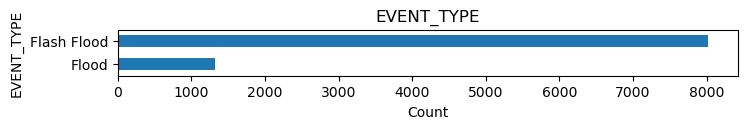






=== MISSING VALUES (robust) for the non_flood_df dataset ===
                      column  missing  missing_%
                 FLOOD_CAUSE     9340     100.34
             EVENT_NARRATIVE     9340     100.34
                snowfall_sum      880       9.45
                    rain_sum      880       9.45
soil_moisture_0_to_10cm_mean       32       0.34
                        YEAR        0       0.00
            cloud_cover_mean        0       0.00
           pressure_msl_mean        0       0.00
           precipitation_sum        0       0.00
           dew_point_2m_mean        0       0.00
   relative_humidity_2m_mean        0       0.00
         temperature_2m_mean        0       0.00
         wind_speed_10m_mean        0       0.00
                       MONTH        0       0.00
                  EVENT_TYPE        0       0.00
                       STATE        0       0.00
                   BEGIN_LON        0       0.00
                   BEGIN_LAT        0       0.00
   

=== non_flood_df DATA SHAPE & COLUMNS ===
Rows: 9,340  |  Columns: 21
Columns: YEAR, MONTH, BEGIN_DAY, BEGIN_TIME, BEGIN_LAT, BEGIN_LON, STATE, EVENT_TYPE, FLOOD_CAUSE, EVENT_NARRATIVE, temperature_2m_mean, wind_speed_10m_mean, cloud_cover_mean, relative_humidity_2m_mean, dew_point_2m_mean, precipitation_sum, rain_sum, snowfall_sum, pressure_msl_mean, soil_moisture_0_to_10cm_mean, elevation

=== HEAD(10) ===
 YEAR  MONTH  BEGIN_DAY  BEGIN_TIME  BEGIN_LAT  BEGIN_LON STATE EVENT_TYPE FLOOD_CAUSE EVENT_NARRATIVE  temperature_2m_mean  wind_speed_10m_mean  cloud_cover_mean  relative_humidity_2m_mean  dew_point_2m_mean  precipitation_sum  rain_sum  snowfall_sum  pressure_msl_mean  soil_moisture_0_to_10cm_mean  elevation
 2001      3          1         140   32.53333  -96.66667 TEXAS     Normal                                        20.508880            22.804094         82.587585                  81.173965          17.613417          13.583580 13.583580           0.0         1009.81480      

/var/folders/sr/wl072k0j639gxnqc7g60nk0h0000gn/T/ipykernel_48964/3167055182.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


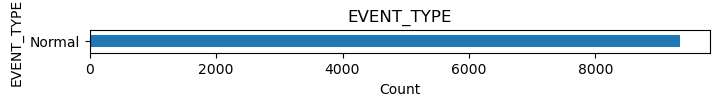






=== MISSING VALUES (robust) for the county_test_df dataset ===
                      column  missing  missing_%
                        YEAR        0        0.0
                       MONTH        0        0.0
soil_moisture_0_to_10cm_mean        0        0.0
           pressure_msl_mean        0        0.0
                snowfall_sum        0        0.0
                    rain_sum        0        0.0
           precipitation_sum        0        0.0
           dew_point_2m_mean        0        0.0
   relative_humidity_2m_mean        0        0.0
            cloud_cover_mean        0        0.0
         wind_speed_10m_mean        0        0.0
         temperature_2m_mean        0        0.0
                        NAME        0        0.0
                   BEGIN_LON        0        0.0
                   BEGIN_LAT        0        0.0
                  BEGIN_TIME        0        0.0
                   BEGIN_DAY        0        0.0
                   elevation        0        0.0


=== county_test_df DATA SHAPE & COLUMNS ===
Rows: 254  |  Columns: 18
Columns: YEAR, MONTH, BEGIN_DAY, BEGIN_TIME, BEGIN_LAT, BEGIN_LON, NAME, temperature_2m_mean, wind_speed_10m_mean, cloud_cover_mean, relative_humidity_2m_mean, dew_point_2m_mean, precipitation_sum, rain_sum, snowfall_sum, pressure_msl_mean, soil_moisture_0_to_10cm_mean, elevation

=== HEAD(10) ===
 YEAR  MONTH  BEGIN_DAY  BEGIN_TIME  BEGIN_LAT   BEGIN_LON     NAME  temperature_2m_mean  wind_speed_10m_mean  cloud_cover_mean  relative_humidity_2m_mean  dew_point_2m_mean  precipitation_sum  rain_sum  snowfall_sum  pressure_msl_mean  soil_moisture_0_to_10cm_mean  elevation
 2025      4          5           0  33.974085  -99.778711    Foard            22.057941            28.050209         47.122765                  39.228798           6.500302           0.000000  0.000000           0.0         1000.57086                      0.166506      479.0
 2025      4          5           0  30.266361  -98.399741   Blanco          

/opt/anaconda3/envs/geoai_env/lib/python3.9/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


   BEGIN_LAT  BEGIN_LON Flood_Zone  Is_In_Floodplain
0   32.53333  -96.66667          X             False
1   33.73333 -102.78333        NaN             False
2   31.46667  -97.71667          X             False
3   33.08333  -97.13333         AE              True
4   33.36667  -97.68333          X             False
   BEGIN_LAT  BEGIN_LON Flood_Zone  Is_In_Floodplain
0   32.53333  -96.66667          X             False
1   33.73333 -102.78333        NaN             False
2   31.46667  -97.71667          X             False
3   33.08333  -97.13333         AE              True
4   33.36667  -97.68333          X             False


In [14]:
flood_df = manip_df(flood_df, 'flood_df', has_label=True)
non_flood_df = manip_df(non_flood_df, 'non_flood_df', has_label=True)
county_test_df = manip_df(county_test_df, 'county_test_df', has_label=False)

flood_df, non_flood_df, county_test_df = categorize_flood_zones(flood_df, non_flood_df, county_test_df)

flood_df = pd.get_dummies(flood_df, columns=['Flood_Zone', 'Is_In_Floodplain'])
non_flood_df = pd.get_dummies(non_flood_df, columns=['Flood_Zone', 'Is_In_Floodplain'])
county_test_df = pd.get_dummies(county_test_df, columns=['Flood_Zone', 'Is_In_Floodplain'])

In [15]:
flood_df.to_csv("./data/cleaned_flood_data.csv", index=False)
non_flood_df.to_csv("./data/cleaned_non_flood_data.csv", index=False)
county_test_df.to_csv("./data/cleaned_county_test_data.csv", index=False)

In [16]:
# explore_numeric("snowfall_sum", flood_df, 'flood_df')
# explore_numeric("rain_sum", flood_df, 'flood_df')
# explore_numeric("soil_moisture_0_to_10cm_mean", flood_df, 'flood_df')
# explore_numeric("precipitation_sum", flood_df, 'flood_df')